<a href="https://colab.research.google.com/github/Fatinishraq47/Sentiment_analysis_using_different_algorithms_and_their_comparison/blob/main/Sentiment_using_different_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import re


**Loading the dataset**

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [3]:
train_set.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


**Looking at the provided dataset**

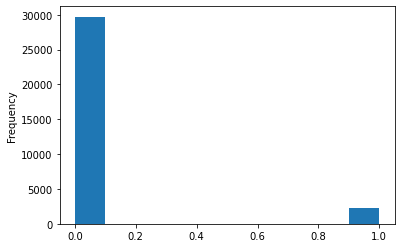

In [4]:
train_set['label'].plot.hist(stacked=True)

**Downloading Stopwords (The Words that do not contribute to the sentiment like "The", "this" etc.)**

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Removing Stopwords**

In [6]:
def remove_stopwords(line):
    word_tokens = word_tokenize(line)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return " ".join(filtered_sentence)

**Preprocessing the lines by removing the stopwords, punctuations and making all the letter to lower case**

In [7]:
def preprocess(line):
    line = line.lower()  #convert to lowercase
    line = re.sub(r'\d+', '', line)  #remove numbers
    line = line.translate(line.maketrans("","", string.punctuation))  #remove punctuation
    line = remove_stopwords(line)
    return line

**Package to tokenize words**

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
for i,line in enumerate(train_set.tweet):
    train_set.tweet[i] = preprocess(line)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Splitting the dataset into train and validation set**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_set['tweet'], train_set['label'], test_size=0.5, stratify=train_set['label'])

trainp=train_set[train_set.label==1]
trainn=train_set[train_set.label==0]
print(trainp.info())
trainn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242 entries, 13 to 31960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2242 non-null   int64 
 1   label   2242 non-null   int64 
 2   tweet   2242 non-null   object
dtypes: int64(2), object(1)
memory usage: 70.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29720 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29720 non-null  int64 
 1   label   29720 non-null  int64 
 2   tweet   29720 non-null  object
dtypes: int64(2), object(1)
memory usage: 928.8+ KB


**Upsampling the negative entries so that we get a balanced dataset**

In [14]:
train_imbalanced = train_set
from sklearn.utils import resample
df_majority = train_set[train_set.label==0]
df_minority = train_set[train_set.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Before")
print(train_set.label.value_counts())
print("After")
print(df_upsampled.label.value_counts())

X_train, X_test, y_train, y_test = train_test_split(df_upsampled['tweet'], df_upsampled['label'], test_size=0.5, stratify=df_upsampled['label'])

Before
0    29720
1     2242
Name: label, dtype: int64
After
1    29720
0    29720
Name: label, dtype: int64


**Using our first algorithm Naive Bayes**

In [16]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

**Giving words a certain value (in this case integers)**

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer()
tf_train=vect.fit_transform(X_train)  #train the vectorizer, build the vocablury
tf_test=vect.transform(X_test)  #get same encodings on test data as of vocabulary built


In [18]:
tf_test_nolabel=vect.transform(test_set.tweet)

In [19]:
model.fit(X=tf_train,y=y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
expected = y_test
predicted=model.predict(tf_test)

**Importing Metrics**

In [22]:
from sklearn import metrics

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95     14860
           1       0.92      0.98      0.95     14860

    accuracy                           0.95     29720
   macro avg       0.95      0.95      0.95     29720
weighted avg       0.95      0.95      0.95     29720

[[13579  1281]
 [  268 14592]]


**Confusion Matrix**

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe9056dbcd0>)

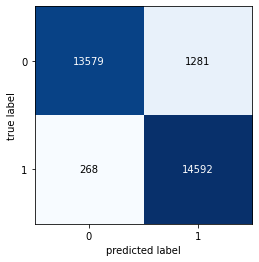

In [23]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(metrics.confusion_matrix(expected, predicted))

**Testing on our test set**

In [24]:
gg=X_test.reset_index(drop=True)

for i, p in enumerate(predicted):
    print (gg[i] + " - " + str(p))
    if i>5:
        break

carlpaladino trump official underfire obama remarks - 1
omg trump suppoers deplorable dumptrump notmypresident deplorable - 1
chick gets fucked videos big asses havin sex - 1
user one cantwait - 0
user also cant love usa hea suppo trump hates half theâ¦ - 1
obama tells trump american people fk leaves cant say anything - 1
user pa locks tv itsmall clip broken quoted days new one - 0


In [25]:
predicted_nolabel=model.predict(tf_test_nolabel)
for i, p in enumerate(tf_test_nolabel):
#     print(i)
    print (test_set.tweet[i] + " - " + str(predicted_nolabel[i]))
    if i>5:
        break 

#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦  - 0
 @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why   - 1
safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!!  - 0
is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite - 0
  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦  - 0
choose to be   :) #momtips  - 0
something inside me dies ð¦ð¿â¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ¦  - 0


**Testing on our custom tweets**

In [26]:
test_custom=pd.DataFrame(["racist", "white judge trial", "it is a horrible incident", "@user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why", " @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why", "@user  at work: attorneys for white officer who shot #philandocastile remove black judge from presiding over trial. htâ¦"])
tf_custom = vect.transform(test_custom[0])
model.predict(tf_custom)

array([1, 1, 1, 1, 1, 1])

**Logistic regression**

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     14860
           1       0.96      0.99      0.98     14860

    accuracy                           0.98     29720
   macro avg       0.98      0.98      0.98     29720
weighted avg       0.98      0.98      0.98     29720

[[14291   569]
 [  127 14733]]


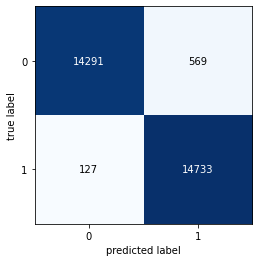

In [27]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X=tf_train,y=y_train)
y_pred_LR = LR.predict(tf_test)
plot_confusion_matrix(metrics.confusion_matrix(expected, y_pred_LR))
print(metrics.classification_report(expected, y_pred_LR))
print(metrics.confusion_matrix(expected, y_pred_LR))

In [28]:
predicted_nolabel_LR=LR.predict(tf_test_nolabel)
for i, p in enumerate(tf_test_nolabel):
#     print(i)
    print (test_set.tweet[i] + " - " + str(predicted_nolabel[i]))
    if i>5:
        break 

#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦  - 0
 @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why   - 1
safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!!  - 0
is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite - 0
  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦  - 0
choose to be   :) #momtips  - 0
something inside me dies ð¦ð¿â¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ¦  - 0


**SVM**

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     14860
           1       0.97      1.00      0.98     14860

    accuracy                           0.98     29720
   macro avg       0.98      0.98      0.98     29720
weighted avg       0.98      0.98      0.98     29720

[[14334   526]
 [   56 14804]]


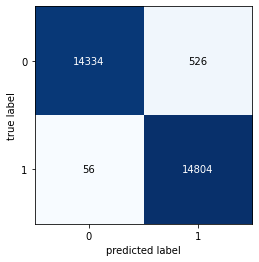

In [29]:
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(tf_train, y_train)
y_pred_SVM = SVM.predict(tf_test)
plot_confusion_matrix(metrics.confusion_matrix(expected, y_pred_SVM))
print(metrics.classification_report(expected, y_pred_SVM))
print(metrics.confusion_matrix(expected, y_pred_SVM))

In [30]:
predicted_nolabel=SVM.predict(tf_test_nolabel)
for i, p in enumerate(tf_test_nolabel):
#     print(i)
    print (test_set.tweet[i] + " - " + str(predicted_nolabel[i]))
    if i>5:
        break 

#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦  - 0
 @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why   - 0
safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!!  - 0
is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite - 0
  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦  - 0
choose to be   :) #momtips  - 0
something inside me dies ð¦ð¿â¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ¦  - 0


**K Neighbours Classifier**

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     14860
           1       0.79      1.00      0.88     14860

    accuracy                           0.86     29720
   macro avg       0.89      0.86      0.86     29720
weighted avg       0.89      0.86      0.86     29720

[[10829  4031]
 [    9 14851]]


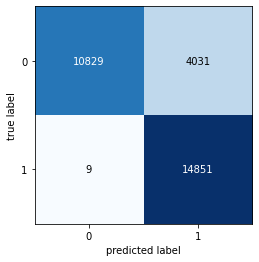

In [31]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 3)
KNN.fit(tf_train, y_train)
y_pred_KNN = KNN.predict(tf_test)
plot_confusion_matrix(metrics.confusion_matrix(expected, y_pred_KNN))
print(metrics.classification_report(expected, y_pred_KNN))
print(metrics.confusion_matrix(expected, y_pred_KNN))

In [32]:
predicted_nolabel=KNN.predict(tf_test_nolabel)
for i, p in enumerate(tf_test_nolabel):
#     print(i)
    print (test_set.tweet[i] + " - " + str(predicted_nolabel[i]))
    if i>5:
        break 

#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦  - 1
 @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why   - 1
safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!!  - 0
is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð   #harrypotter #pottermore #favorite - 0
  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦  - 0
choose to be   :) #momtips  - 1
something inside me dies ð¦ð¿â¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ¦  - 1


In [33]:
test_custom=pd.DataFrame(["racist", "white judge trial", "it is a horrible incident", "@user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why", " @user #white #supremacists want everyone to see the new â  #birdsâ #movie â and hereâs why", "@user  at work: attorneys for white officer who shot #philandocastile remove black judge from presiding over trial. htâ¦"])
tf_custom = vect.transform(test_custom[0])
LR.predict(tf_custom)

array([1, 1, 0, 1, 1, 1])

In [34]:
SVM.predict(tf_custom)

array([1, 1, 0, 0, 0, 1])

In [35]:
KNN.predict(tf_custom)

array([1, 1, 1, 1, 1, 1])